# Adjusted Phase 1  Generation Tool
Below are packages imported during development, most of which are used below
Read through the worksheet, and enter any values in the cells headed 'Enter' below.  Then click 'Cell' in the menu above, and 'Run All.'

In [54]:
%matplotlib inline

import matplotlib as mp

import pandas as pd

import numpy as np

import scipy as sp

import scipy.linalg as spl

import glob

import json

import urllib2

from datetime import datetime 

import matplotlib.pyplot as pl

import re

import obspy

from obspy.core import UTCDateTime

import geomagio

from geomagio.edge import EdgeFactory

#from geomagio.Algorithm import DeltaFAlgorithm

Example url for baseline web service

https://geohazards.usgs.gov/baselines/observation.json.php?observatory=BOU&starttime=2016-01-01&endtime=2016-10-07

## Enter the Observatory in the cell below as a string, similar to the following example:

```python
obs_code = 'BOU'
```

In [55]:
obs_code = 'BOU'

## Enter the start date and end date for which you'd like to request baseline measurements
If you choose a year's worth, that will result in the mean delta F for adjusted data being closest to 0, but will amplify the daily variation.  If you choose a shorter time period closer to the present, the daily variation will remain small, but the mean delta F will be biased by seasonal variation.  If the baseline service is called without dates, it will return the last one month's baseline measurements.

In [56]:
start_date = '2015-10-10'

In [57]:
end_date = '2016-10-09'

In [58]:
baseline_url = 'https://geohazards.usgs.gov/baselines/observation.json.php'
full_url = baseline_url + '?observatory=' + obs_code + '&starttime=' + start_date + '&endtime=' + end_date
response = urllib2.urlopen(full_url)
parsed_response = json.load(response)


In [59]:
h_abs = []
d_abs = []
z_abs = []
h_ord = []
d_ord = []
z_ord = []
h_t = []
d_t = []
z_t = []

for datum in parsed_response['data']:
    for reading in datum['readings']:
        if (reading['H']['absolute'] is not None
           and reading['D']['absolute'] is not None
           and reading['Z']['absolute'] is not None
           and reading['H']['baseline'] is not None
           and reading['D']['baseline'] is not None
           and reading['Z']['baseline'] is not None
           and reading['H']['valid'] is True
           and reading['D']['valid'] is True
           and reading['Z']['valid'] is True):
            h_abs.append(reading['H']['absolute'])
            d_abs.append(reading['D']['absolute'])
            z_abs.append(reading['Z']['absolute'])
            h_ord.append(reading['H']['absolute'] - reading['H']['baseline'])
            d_ord.append(reading['D']['absolute'] - reading['D']['baseline'])
            z_ord.append(reading['Z']['absolute'] - reading['Z']['baseline'])
            h_t.append(reading['H']['end'])
            d_t.append(reading['D']['end'])
            z_t.append(reading['Z']['end'])
            
last_datum = parsed_response['data'][1]
pier_correction = last_datum['pier']['correction']
pier_correction

-22

## Plot of H absolutes, ordinates, baselines
Absolutes are in the top plot below, in blue.  These represent the field, as measured by the overhauser (with the pier correction applied), with direction measured by the theodolite.  Ordinates are also in the top plot, in green.  They represent the variometer's reading of the field corresponding to the times absolute measurements are taken.  Baselines, or the difference between the two are in the bottom plot, in blue.  Vertical axis units are nanoteslas.  Horizontal axis units are unix timestamp (seconds since Jan 1, 1970).

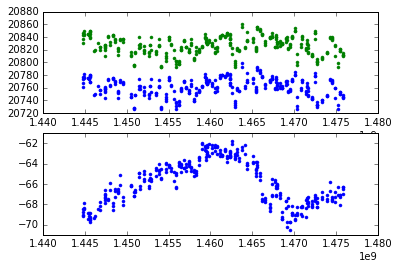

In [60]:
pl.subplot(2,1,1)
pl.plot(h_t,h_abs,'.',h_t,h_ord,'.')
pl.subplot(2,1,2)
pl.plot(h_t,np.asarray(h_abs) - np.asarray(h_ord),'.')

## Plot of D absolutes, ordinates, baselines
Absolutes are in the top plot below, in blue.  These represent the declination angle of the field, as measured by the overhauser (with the pier correction applied), with direction measured by the theodolite.  Ordinates are also in the top plot, in green.  They represent the declination (from the sensor's H axis) calculated from the variometer's reading of the field corresponding to the times absolute measurements are taken.  Baselines, or the difference between the two are in the bottom plot, in blue.  Vertical axis units are degrees.  Horizontal axis units are unix timestamp (seconds since Jan 1, 1970).

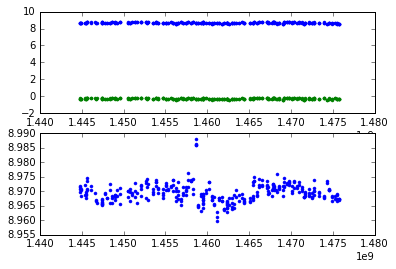

In [61]:
pl.subplot(2,1,1)
pl.plot(d_t,d_abs,'.',d_t,d_ord,'.')
pl.subplot(2,1,2)
pl.plot(d_t,np.asarray(d_abs) - np.asarray(d_ord),'.')

## Plot of Z absolutes, ordinates, baselines
Absolutes are in the top plot below, in blue. These represent the field, as measured by the overhauser (with the pier correction applied), with direction measured by the theodolite. Ordinates are also in the top plot, in green. They represent the variometer's reading of the field corresponding to the times absolute measurements are taken. Baselines, or the difference between the two are in the bottom plot, in blue. Vertical axis units are nanoteslas. Horizontal axis units are unix timestamp (seconds since Jan 1, 1970).

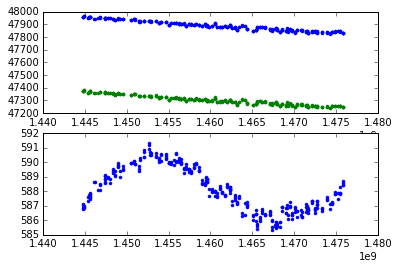

In [62]:
pl.subplot(2,1,1)
pl.plot(z_t,z_abs,'.',z_t,z_ord,'.')
pl.subplot(2,1,2)
pl.plot(z_t,np.asarray(z_abs) - np.asarray(z_ord),'.')

### Note about averaging
The baselines have up to four values, corresponding to the up to four sets measured by the observer.  Pre-averaging these does not improve the transformation matrix calculated by the least squares solver in scipy/numpy.

## Calculate h,e,Z from H,D,Z

In [63]:
h_abs_n = np.asarray(h_abs)
d_abs_n = np.asarray(d_abs)
z_abs_n = np.asarray(z_abs)
h_ord_n = np.asarray(h_ord)
d_ord_n = np.asarray(d_ord)
z_ord_n = np.asarray(z_ord)
z_t_n = np.asarray(z_t)

In [64]:
h_a = h_abs_n*np.cos(d_abs_n*np.pi/180)
e_a = h_abs_n*np.sin(d_abs_n*np.pi/180)
z_a = z_abs_n
h_o = h_ord_n*np.cos(d_ord_n*np.pi/180)
e_o = h_ord_n*np.sin(d_ord_n*np.pi/180)
z_o = z_ord_n

## Calculate Transform matrix

In [65]:
abs_st = np.vstack([h_a,e_a,z_a,np.ones_like(h_a)])
ord_st = np.vstack([h_o,e_o,z_o,np.ones_like(h_o)])
M, res, rank, sigma = spl.lstsq(ord_st.T,abs_st.T)
tol = 1e-9
maskM = np.abs(M) > tol
M = maskM * M
M = M.T
M

array([[  9.81546858e-01,  -1.89150435e-01,   6.19830586e-03,
         -2.32136980e+02],
       [  1.50583668e-01,   9.94985961e-01,  -2.27063235e-03,
          2.09168024e+02],
       [ -4.30853583e-02,  -2.01141374e-03,   1.02449397e+00,
          3.26623382e+02],
       [ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
          1.00000000e+00]])

## Enter path to save adjusted statefile

In [66]:
path = '/users/aclaycomb/'

In [67]:
data = {
            'M11': M[0,0],
            'M12': M[0,1],
            'M13': M[0,2],
            'M14': M[0,3],
            'M21': M[1,0],
            'M22': M[1,1],
            'M23': M[1,2],
            'M24': M[1,3],
            'M31': M[2,0],
            'M32': M[2,1],
            'M33': M[2,2],
            'M34': M[2,3],
            'M41': M[3,0],
            'M42': M[3,1],
            'M43': M[3,2],
            'M44': M[3,3],
            'PC':  pier_correction
        }
with open(path + 'adj' + obs_code + '_state_.json', 'w') as f:
            f.write(json.dumps(data))

In [68]:
factory = EdgeFactory()

## Enter Start and End Times for Test month(s)

In [69]:
start2=UTCDateTime('2016-06-09T00:00:00Z')

In [70]:
end2=UTCDateTime('2016-10-08T23:59:59Z')

In [71]:
hezf = factory.get_timeseries(observatory=obs_code,

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=start2,

        endtime=end2)

In [72]:
raw = np.vstack([hezf[0].data,hezf[1].data,hezf[2].data,np.ones_like(hezf[0].data)])
adj = np.dot(M,raw)

In [73]:
h_pqqm = np.mean(h_a - h_o)

e_pqqm = np.mean(e_a - e_o)

z_pqqm = np.mean(z_a - z_o)

## Plot of $\Delta F$ Over the Test Period
The left plot (black) shows adjusted delta F, the cyan shows adjusted delta F using average baselines over the period (instead of the transformation.  The blue on the right shows raw delta F.

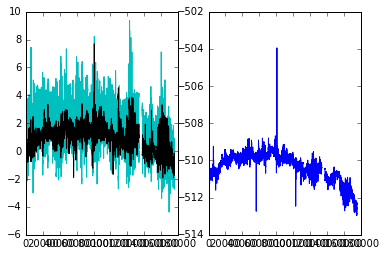

In [74]:
pl.figure()

pl.subplot(1,2,1)


pl.plot(((hezf[0].data + h_pqqm)**2 + (hezf[1].data + e_pqqm)**2 + (hezf[2].data + z_pqqm)**2)**(0.5) - 
        hezf[3].data - pier_correction,'c')

pl.hold(True)

pl.plot((adj[0]**2 + adj[1]**2 + adj[2]**2)**(0.5) - hezf[3].data - pier_correction,'k')

#pl.ylim(-30,30)

pl.subplot(1,2,2)

pl.plot(((hezf[0].data)**2 + (hezf[1].data)**2 + (hezf[2].data)**2)**(0.5) - hezf[3].data - pier_correction,'b')

#pl.ylim(-539,-479)

## Plots of Raw h, Adjusted X, and '$\Delta h$'

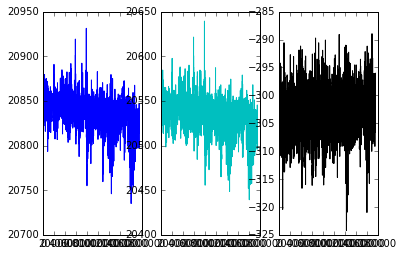

In [75]:
pl.subplot(1,3,1)
pl.plot(hezf[0],'b')
pl.subplot(1,3,2)
pl.plot(adj[0],'c')
pl.subplot(1,3,3)
pl.plot(adj[0] - hezf[0],'k')

## Plots of Raw e, Adjusted Y, and '$\Delta e$'

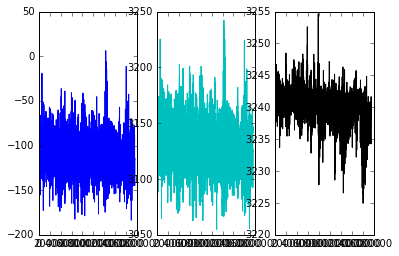

In [76]:
pl.subplot(1,3,1)
pl.plot(hezf[1],'b')
pl.subplot(1,3,2)
pl.plot(adj[1],'c')
pl.subplot(1,3,3)
pl.plot(adj[1] - hezf[1],'k')

## Plots of Raw z, Adjusted Z, and '$\Delta z$'

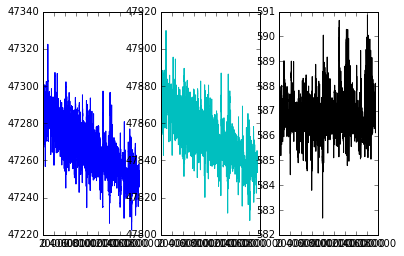

In [77]:
pl.subplot(1,3,1)
pl.plot(hezf[2],'b')
pl.subplot(1,3,2)
pl.plot(adj[2],'c')
pl.subplot(1,3,3)
pl.plot(adj[2] - hezf[2],'k')